Lets build our own Mean Shift algorithm from scratch.  
Lets begin with imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

Lets create some sample data

In [2]:
X = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8 ],
              [8, 8],
              [1, 0.6],
              [9,11],
              [8,2],
              [10,2],
              [9,3],])

Lets see the data on graph

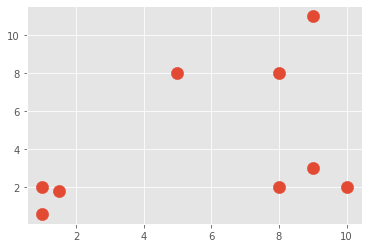

In [3]:
plt.scatter(X[:,0], X[:,1], s=150)
plt.show()

Lets begin developing our MeanShift class.  
Recall the method for Mean Shift is:
1. Make all datapoints centroids.
2. Take mean of all featuresets within centroid's radius, setting this mean as new centroid.
3. Repeat step #2 until convergence.  

In the code below, we begin iterating through each centroid, and finding all featuresets in range. From there, we are taking the average, and setting that average as the "new centroid." Finally, we're creating a uniques variable, which tracks the sorted list of all known centroids. We use set here since there may be duplicates, and duplicate centroids are really just the same centroid.  
Then we note the previous centroids, before we begin to reset "current" or "new" centroids by setting them as the uniques. Finally, we compare the previous centroids to the new ones, and measure movement. If any of the centroids have moved, then we're not content that we've got full convergence and optimization, and we want to go ahead and run another cycle. If we are optimized, we break, and then finally set the centroids attribute to the final centroids we came up with.

In [4]:
class MeanShift:
    def __init__(self, radius=4):
        self.radius = radius
        
    def fit(self, data):
        centroids = {}
        
        # in the beginning, every feature is a centroid
        for i in range(len(data)):
            centroids[i] = data[i]
            
        while True:
            new_centroids = []
            
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                
                for featureset in data:
                    if np.linalg.norm(featureset - centroid) < self.radius:
                        in_bandwidth.append(featureset)
                        
                new_centroid = np.average(in_bandwidth, axis=0)
                new_centroids.append(tuple(new_centroid))
                
            uniques = sorted(list(set(new_centroids)))
            
            prev_centroids = dict(centroids)
            
            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])
                
            optimized = True
            
            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                    break
                    
            if optimized:
                break
                
        self.centroids = centroids
        

## Training

In [5]:
clf = MeanShift()
clf.fit(X)

Lets retrieve the centroids and plot them along with our datapoints

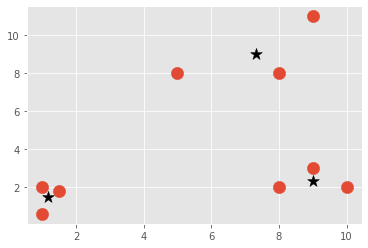

In [6]:
centroids = clf.centroids

plt.scatter(X[:,0], X[:,1], s=150)

for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], color='k', marker='*', s=150)

plt.show()

One issue here is we've basically hard-coded the radius. It's not dynamic at all, and this is supposed to be unsupervised machine learning. Imagine if we had 50 dimensions? It wouldn't be so simple. Can a machine look at the dataset and come up with something decent?  
Yes. We'll add that to the MeanShift class now.  
(We're going to use much of the code from same `MeanShift` class above and add on to it).  

- The plan here is to create a massive radius, but make that radius go in steps, like bandwidths, or a bunch of radiuses with different lengths, which we'll call steps. If a featureset is in the closest radius, it will have a much higher "weight" than one much further away. 
- Next, if the user hasn't hard-coded the radius, then we're going to find the "center" of **all** of the data. Then, we will take the norm of that data, then we assume that each radius with self.radius is basically the full data-length, divided by how many steps we wanted to have. From here the centroids definitions remain the same as before in the above code. 
- The weights list is just a simple list that we'll take how many "radius steps" a featureset is from the centroid, take those number of steps, treating them as index values for the weight list. Iterating through the features, we calculate distances, add weights, then add the "weighted" number of centroids to the `in_bandwidth`. When all done, we take the average of `in_bandwidth`, making that the new centroid.
- Next, earlier, all we had to do to note convergence was remove the centroids that were identical to eachother. With this method, however, it is highly likely that we have centroids that are extremely close, but not identical. We want to merge these too.
- Next, we will add code for "fit" method to also classify the existing featuresets.
- Finally, we add a predict method as well

In [7]:
class MeanShiftDynamic:
    def __init__(self, radius=None, radius_norm_step=100):
        self.radius = radius
        self.radius_norm_step = radius_norm_step
        
    def fit(self, data):
        
        if self.radius == None:
            all_data_centroid = np.average(data, axis=0)
            all_data_norm = np.linalg.norm(all_data_centroid)
            self.radius = all_data_norm / self.radius_norm_step
            
        centroids = {}
        
        # in the beginning, every feature is a centroid
        for i in range(len(data)):
            centroids[i] = data[i]
           
        # creating the list using norm_step in reverse order i.e [100, 99, 98,...,3, 2, 1] 
        weights = [i for i in range(self.radius_norm_step)][::-1]
        while True:
            new_centroids = []
            
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                
                for featureset in data:
                    distance = np.linalg.norm(featureset - centroid)
                    if distance == 0:
                        distance = 0.0000000001
                        
                    weight_index = int(distance / self.radius)
                    
                    if weight_index > self.radius_norm_step - 1:
                        weight_index = self.radius_norm_step - 1
                        
                    to_add = (weights[weight_index] ** 2) * [featureset]
                    in_bandwidth += to_add
                        
                new_centroid = np.average(in_bandwidth, axis=0)
                new_centroids.append(tuple(new_centroid))
                
            uniques = sorted(list(set(new_centroids)))
            
            to_pop = []
            
            for i in uniques:
                for ii in [i for i in uniques]:
                    if i == ii:
                        pass
                    elif np.linalg.norm(np.array(i) - np.array(ii)) <= self.radius:
                        to_pop.append(ii)
                        break
                        
                for i in to_pop:
                    try:
                        uniques.remove(i)
                    except:
                        pass
                    
            
            prev_centroids = dict(centroids)
            
            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])
                
            optimized = True
            
            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                    break
                    
            if optimized:
                break
                
        self.centroids = centroids
        
        self.classifications = {}
        
        for i in range(len(self.centroids)):
            self.classifications[i] = []
            
        for featureset in data:
            distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in centroids]
            classification = (distances.index(min(distances)))
            
            self.classifications[classification].append(featureset)
            
    def predict(self, data):
        distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in centroids]
        classification = (distances.index(min(distances)))
            
        self.classifications[classification].append(featureset)
            

We can test this using same data we previously used

{0: array([1.18211438, 1.50109686]), 1: array([7.45598917, 8.44263203]), 2: array([8.97302521, 2.50551952])}


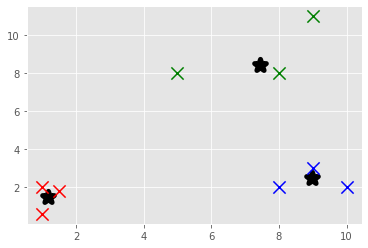

In [8]:
clf = MeanShiftDynamic()
clf.fit(X)

centroids = clf.centroids
print(centroids)

colors = 10*['r','g','b','c','k','y']

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0],featureset[1], marker = "x", color=color, s=150, linewidths = 5, zorder = 10)

for c in centroids:
    plt.scatter(centroids[c][0],centroids[c][1], color='k', marker = "*", s=150, linewidths = 5)

plt.show()

We can put our clustering algorithm through a real stress test with Scikit-Learn's make_blobs, which we can use to create featuresets.

In [9]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=15, centers=3, n_features=2)

f:\projects\myprojects\machinelearning\mlenv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


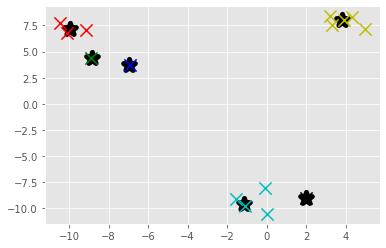

In [10]:
clf = MeanShiftDynamic()
clf.fit(X)

centroids = clf.centroids

colors = 10*['r','g','b','c','k','y']

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0],featureset[1], marker = "x", color=color, s=150, linewidths = 5, zorder = 10)

for c in centroids:
    plt.scatter(centroids[c][0],centroids[c][1], color='k', marker = "*", s=150, linewidths = 5)

plt.show()